In [2]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes

Populating the interactive namespace from numpy and matplotlib


In [3]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [10]:
oldinp = "../indata/DFDgoddamnit.inp"
fn = "../indata/DFD_crap"
Mi = 10
Nt = 1
Nstar = 5
Np  =5
Nn = 6
L = 10
T = 20
a = 120
D = .1
Ls = [L]*Np
Ns = [int(l) for l in Ls]
#jt = [1,3,1,3,1,3,1,1]#for DFDpleasework.inp
jt = [1,2,3,1,2,1]    #forDFDgoddamnit.inp
#jt = [1,2,2,2,2,2,2,1]
bt = [1,1,1,1,1,1]
bv = [0,0,0,0,0,0]
r =  [0,0,0,0,0,0]
r =  [0,-1,-1,-1,-1,-1]
h0s = [0]*Np
q0s = [0]*Np
dx = [L/Ns[0]]
Mrs = [0.015,.0015,.015,.015,.015]
Mrs = [0.008,.008,.008,.008,.008]
Mrs = [0.01]*Nn
#Mrs = [0]*Nn
elevs = [0]*Nn
#elevs =[10,9,8,7,6,5,4,3]
#elevs =[10, 9,8,5,6,4,4,3]
#elevs = [10,9,8,7,6,5,4,3]
#elevs = [10,9.5,9,8.5,8,7,6,3]
elevs = [10, 9,9,9,9,10]
#elevs  =[10]*Nn
Ds = [D,D,D,D,D]
M = max(int(T*a/(max(dx)*.8))*5,1)
Ls = [L]*Np
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)
dt = T/float(M)
Hs =np.zeros((M/Mi*Nt,sum(Ns)))#[H0(t0), H1(t0),,,H7(t0);H0(t1)...; ]
Qs =np.zeros((M/Mi*Nt,sum(Ns)))
Us =np.zeros((M/Mi*Nt,sum(Ns)))
print Mi
print M

new files are ../indata/DFD_crap.inp and ../indata/DFD_crap.config
10
15000


In [11]:
n1 = PyNetwork(fi,fc,1)
Q00 = 0.0087
j = 0
p0 = PyPipe_ps(n1.Ns[j],n1.Ds[j], n1.Ls[j],M,a)
Ain = p0.AofH(10.,False)
Q0 = Q00*np.ones(M+1)
A00 = Ain*np.ones(M+1)
n1.setbVal(0,Q0)
A0 = Ain*np.ones(Ns[0])
Q0 = Q00*np.ones(Ns[0])
#for k in range(1):
n1.setIC(0,A0,Q0)
#n1.showCurrentData()

In [12]:
Vs = [n1.getTotalVolume()]
dHs = []
for mm in range(Nt):
    n1.runForwardProblem(dt)
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        for m in range(1,M+1,Mi):     
            Htemp=[p0.pbar(qh[idx_t(0,k,m,N)],False) for k in range(1,N+1)]
            #Qtemp = [qh[idx_t(1,k,m,N)] for k in range(1,N+1)]
            Utemp = [qh[idx_t(1,k,m,N)]/max(0,qh[idx_t(0,k,m,N)]) for k in range(1,N+1)]
            Hs[(m-1)/Mi+mm*(M/Mi),j*N:(j+1)*N] = Htemp
            Us[(m-1)/Mi+mm*(M/Mi),j*N:(j+1)*N] = Utemp
            #Qs[(m-1)/Mi+mm*(M/Mi),j*N:(j+1)*N] = Qtemp
        #print Htemp
    Vs.append(n1.getTotalVolume()) 
    dHs.append([n1.getAveGradH(i) for i in range(M+1)])
    n1.reset()


/Users/lieba/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


In [13]:
print len(range(1,M+1,Mi))
print M/Mi
print n1.conn
print shape(Hs)


1500
1500
[[0 1]
 [1 2]
 [2 4]
 [2 3]
 [3 5]]
(1500, 50)


In [14]:
m32gal=264.172052
print (Vs[-1]-Vs[0])*m32gal

print T*Nt

41.0059079334
20


0.155224247315
(1500, 50)
20
[0.07906897835233516, 0.23429322566733776]


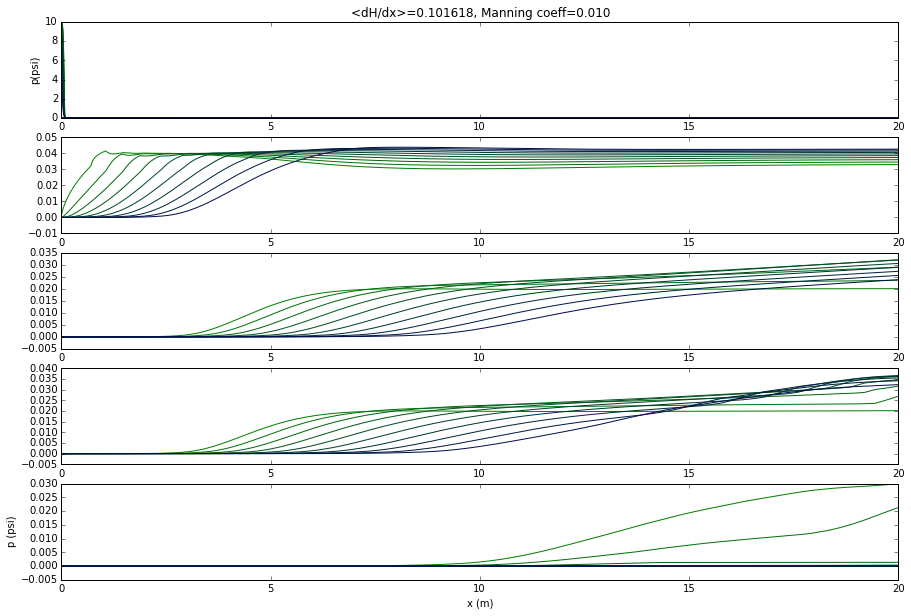

In [15]:
m2psi = 1.42
from matplotlib import cm
import matplotlib.colors as colors  
cNorm  = colors.Normalize(vmin=0, vmax=30)
fig,ax = plt.subplots(nrows=Np, figsize=(15,10))
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean'))
Ttot= T*Nt
t=linspace(0,T*Nt,Nt*M/Mi)
MM=M/Mi-1
x = linspace(0,L,N)
for n in range(0,10):
    for j in range(0,Np):
        ax[j].plot(t,Hs[:,j*N+n], color = scalarMap.to_rgba(n), label = "pipe %d"%j)
        #ax[j].plot(x,Hs[n*740,j*N:(j+1)*N],color = scalarMap.to_rgba(n))
        #ax[j].set_xlim((35,40))
        #ax[j].set_ylim(0,1)
        #xlim(0,50)
#legend(ncol=3, loc = 'lower right')
ylabel('p (psi)')
xlabel('t (s)')
ax[0].set_title('<dH/dx>=%f, Manning coeff=%.3f'%(mean(dHs), Mrs[0]))
#ax[0].set_ylim(0,35)
ax[0].set_ylabel('p(psi)')
ax[Np-1].set_xlabel('x (m)')
#ax[Np-1].set_xlabel('t(s)')
print Vs[-1]-Vs[0]
print shape(Hs)
print T*Nt
print Vs

In [176]:
dHdt_ = np.zeros(Np) 
K1 = M/Mi*Nt-2
K2 = K1/2+3000
print K1
print K2
print t[K1]
print t[K2]
DeltaT = t[K1]-t[K2]
print DeltaT
for i in range(Np):
    dHdt_[i] = (Hs[K1,i*N+5]-Hs[K2,i*N+5])/(DeltaT)
dHdt.append(dHdt_)
MrVals.append(Mrs[0])

SyntaxError: invalid syntax (<ipython-input-176-f418edce55e0>, line 1)

[ 3.07152425  3.06998531  2.22067382  3.46938516  3.46800968]
[[ 3.07152425  3.06998531  2.22067382  3.46938516  3.46800968]
 [ 3.05967147  3.05814764  2.51324511  3.4180937   3.41788122]
 [ 3.17806492  3.17653214  2.90891598  3.40020787  3.40081735]
 [ 3.46871754  3.46727538  3.43409583  3.543119    3.54366842]
 [ 3.66080167  3.6600785   3.70504426  3.67241826  3.67303884]]
[ 3.06998531  3.05814764  3.17653214  3.46727538  3.6600785 ]
[0.0, 0.001, 0.002, 0.004, 0.008]


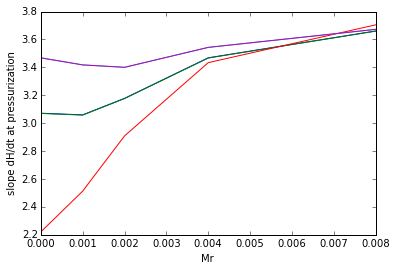

In [177]:
#dHdt[-1] = dHdt_
print dHdt[0]
slopes = np.array(dHdt)
print slopes
print slopes[:,1]
print MrVals
for i in range(Np):
    plot(MrVals,slopes[:,i])
xlabel('Mr')
ylabel('slope dH/dt at pressurization')

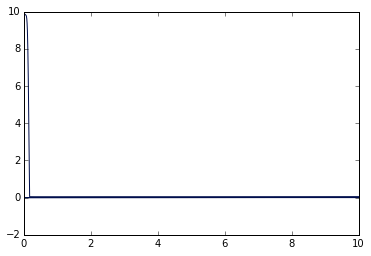

In [10]:

t = linspace(0,T*Nt,shape(Hs)[0])
for j in range(Np):
    plot(t,Hs[:,j*N+1],color = scalarMap.to_rgba(n))

(0, 11)

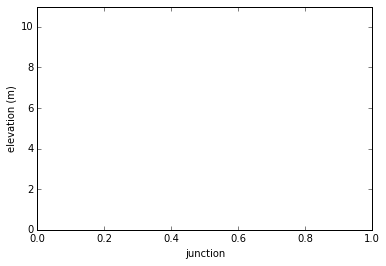

In [29]:
Ltot = 0
E = elevs[0]
xs = []
#fig,ax = plt.subplots(figsize=(15,5))
for k in range(Nn-1):
    L = n1.Ls[k]
    x = linspace(0,L)
    cval = scalarMap.to_rgba(k)
    ax[1].plot(x+Ltot,x*(elevs[k+1]-elevs[k])/L+E,color = cval, lw = 2)
    xs.append(Ltot)
    Ltot+=L
    E = elevs[k+1]
xs.append(Ltot)
#ax.set_xticks(xs);
#ax.xaxis.grid(True)
#ax.set_xticklabels(arange(0,Nn+1));
ylabel('elevation (m)')
xlabel('junction')
ylim(0,11)

In [34]:
m32gal=264.172052
print "a = %f m/s" %a
print "inflow volume = %.2f gallons"%((Vs[-1]-Vs[0])*m32gal)

a = 120.000000 m/s
inflow volume = 42.13 gallons


0.000115042548567


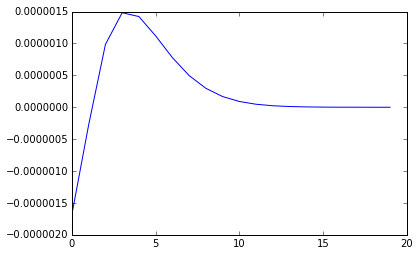

In [152]:
cNorm2  = colors.Normalize(vmin=0, vmax=50)
map2 = cm.ScalarMappable(norm=cNorm2, cmap=cm.get_cmap('gray'))
diffs = Hs[:,3*N:4*N]-Hs[:,2*N:3*N]
print norm(diffs)/(M/Mi)
plot(diffs[300,:])


In [26]:
print M


[[0 1]
 [1 2]
 [2 4]
 [2 3]
 [3 5]]


In [106]:
print Mi

10


In [46]:
j = 0
p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
ys = linspace(0,.01)
thetas = [2*arccos(1.-2*y/D) for y in ys]


In [47]:
print ys

[ 0.          0.00020408  0.00040816  0.00061224  0.00081633  0.00102041
  0.00122449  0.00142857  0.00163265  0.00183673  0.00204082  0.0022449
  0.00244898  0.00265306  0.00285714  0.00306122  0.00326531  0.00346939
  0.00367347  0.00387755  0.00408163  0.00428571  0.0044898   0.00469388
  0.00489796  0.00510204  0.00530612  0.0055102   0.00571429  0.00591837
  0.00612245  0.00632653  0.00653061  0.00673469  0.00693878  0.00714286
  0.00734694  0.00755102  0.0077551   0.00795918  0.00816327  0.00836735
  0.00857143  0.00877551  0.00897959  0.00918367  0.00938776  0.00959184
  0.00979592  0.01      ]
